## Generative Latent Replay with GMMs

Code to test latent replay on benchmark problems and compare with proposed generative latent replay strategies i.e. normalising bottleneck representations and sampling from fitted GMM on latent space.

In [1]:
# ML imports
import torch
import torch.nn as nn
from torch.optim import SGD
from torch.nn import CrossEntropyLoss
from torchvision import transforms

from avalanche.training import Naive
from avalanche.models import SimpleMLP #, SimpleCNN
from avalanche.benchmarks.classic import PermutedMNIST #,PermutedOmniglot, RotatedOmniglot

from matplotlib import pyplot as plt

# Local imports
import models
import utils
from nets import SimpleCNN

In [2]:
# Config
device = utils.get_device()

model = 'mlp'
n_classes = 10
n_epochs = 1 #5
latent_layer_number = 1
n_experiences = 5
input_size = 784

if model=='mlp':
    penultimate_layer_dim = 128 #512
    model = SimpleMLP(
        input_size=input_size, 
        hidden_layers=1,
        num_classes=n_classes, 
        hidden_size=penultimate_layer_dim
        )
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: torch.flatten(x))])
    
elif model=='cnn':
    model = SimpleCNN(num_classes=n_classes)
    penultimate_layer_dim = 64
    transform = transforms.Compose([
        transforms.ToTensor()
    ])

else:
    # CL Benchmark Creation
    # Original AR1* usese CORE50 (n,3,128,128) and pretrained mobilenet
    transform = transforms.Compose([
        #transforms.Lambda(lambda x: x.convert('RGB')),
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1))
    ])

In [3]:
model_2 = SimpleMLP(
        input_size=input_size, 
        hidden_layers=1,
        num_classes=n_classes, 
        hidden_size=penultimate_layer_dim
        )

# Prepare for training & testing
criterion = CrossEntropyLoss()

l2 = 0.0005
momentum = 0.9
lr = 0.001

cl_strategy_naive = Naive(
    model=model_2,
    criterion=criterion, 
    optimizer = SGD(model_2.parameters(), lr=lr, momentum=momentum, weight_decay=l2),
    train_mb_size=32, 
    train_epochs=n_epochs, 
    eval_mb_size=32,
    device=device
    )

# train and test loop over the stream of experiences
results_naive = []

In [4]:
# Prepare for training & testing
criterion = CrossEntropyLoss()

# Continual learning strategy
#cl_strategy = models.LatentReplay(criterion, train_mb_size=32, train_epochs=2, eval_mb_size=32, device=device) 

cl_strategy = models.AR1(
    model=model, 
    penultimate_layer_dim=penultimate_layer_dim,
    criterion=criterion, 
    train_mb_size=32, 
    train_epochs=n_epochs, 
    eval_mb_size=32, 
    latent_layer_num=latent_layer_number, 
    freeze_below_layer=f"lat_features.{latent_layer_number-1}", 
    device=device
    )

# train and test loop over the stream of experiences
results_ar1 = []

FrozenNet(
  (lat_features): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU(inplace=True)
  )
  (end_features): Sequential(
    (0): Dropout(p=0.5, inplace=False)
  )
  (output): Linear(in_features=128, out_features=10, bias=False)
)


c:\Users\jacob\Documents\GitHub\generative-latent-replay\models\ar1.py:109: UserWarning: The AR1 strategy implementation is in an alpha stage and is not perfectly aligned with the paper implementation. Please use at your own risk!
  warnings.warn(


In [5]:
for model, results in [(cl_strategy, results_ar1), (cl_strategy_naive, results_naive)]:
    perm_mnist = PermutedMNIST(n_experiences=n_experiences, train_transform=transform, eval_transform=transform)
    train_stream = perm_mnist.train_stream
    test_stream = perm_mnist.test_stream
    
    for train_exp in train_stream:
        model.train(train_exp)
        results.append(model.eval(test_stream))

-- >> Start of training phase << --
100%|██████████| 1875/1875 [00:49<00:00, 37.92it/s]
Epoch 0 ended.
	Loss_Epoch/train_phase/train_stream/Task000 = 1.3398
	Top1_Acc_Epoch/train_phase/train_stream/Task000 = 0.6408
-- >> End of training phase << --
-- >> Start of eval phase << --
-- Starting eval on experience 0 (Task 0) from test stream --
100%|██████████| 313/313 [00:05<00:00, 54.08it/s]
> Eval on experience 0 (Task 0) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task000/Exp000 = 0.5450
	Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp000 = 0.8676
-- Starting eval on experience 1 (Task 1) from test stream --
100%|██████████| 313/313 [00:06<00:00, 51.78it/s]
> Eval on experience 1 (Task 1) from test stream ended.
	Loss_Exp/eval_phase/test_stream/Task001/Exp001 = 2.4731
	Top1_Acc_Exp/eval_phase/test_stream/Task001/Exp001 = 0.0757
-- Starting eval on experience 2 (Task 2) from test stream --
100%|██████████| 313/313 [00:06<00:00, 49.46it/s]
> Eval on experience 2 (Task 2) fro

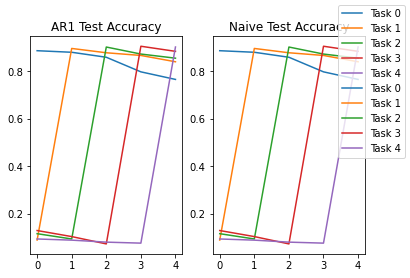

In [9]:
# JA: Next step - replace internal model.
# - model def ✅
# - frozen layer name ✅
# - batch renorm stuff...?

# JA: 2nd step
# - make GMM
# - add GMM to model sampler

def plotplot(results, method_name, ax):
    results_clean = {"train":{'acc':[], 'loss':[]}, "test":{'acc':[], 'loss':[]}}
    loss_prefix = 'Loss_Stream/eval_phase/test_stream/'
    acc_prefix = 'Top1_Acc_Stream/eval_phase/test_stream/'
    
    results_clean["test"]['loss'] = [[result[f'{loss_prefix}Task{str(i).zfill(3)}'] for i in range(n_experiences)] for result in results]
    results_clean["test"]['acc'] = [[result[f'{acc_prefix}Task{str(i).zfill(3)}'] for i in range(n_experiences)] for result in results]
        
       # results_clean["train"]['loss'].append([
       #     result['Loss_Epoch/train_phase/train_stream/Task000'], 
       #     result['Loss_Epoch/train_phase/train_stream/Task001'], 
       #     result['Loss_Epoch/train_phase/train_stream/Task002']])
    
    res = results_clean["test"]['acc']
    
    ax.plot(res, label=[f'Task {i}' for i in range(len(res))])
    ax.set_title(f'{method_name} Test Accuracy')
    
    return results_clean

fig, axes = plt.subplots(1,2)

results_ar1_clean = plotplot(results, 'AR1', axes[0])
results_naive_clean = plotplot(results_naive, 'Naive', axes[1])

fig.legend()


In [10]:
print(results_ar1_clean["test"]['acc'])

print(results_naive_clean["test"]['acc'])

[[0.8874, 0.0895, 0.1163, 0.1296, 0.094], [0.8808, 0.8969, 0.094, 0.1041, 0.0891], [0.8598, 0.8787, 0.9029, 0.0732, 0.0807], [0.7983, 0.8674, 0.8733, 0.9062, 0.0765], [0.7664, 0.8408, 0.8559, 0.8847, 0.903]]
[[0.8874, 0.0895, 0.1163, 0.1296, 0.094], [0.8808, 0.8969, 0.094, 0.1041, 0.0891], [0.8598, 0.8787, 0.9029, 0.0732, 0.0807], [0.7983, 0.8674, 0.8733, 0.9062, 0.0765], [0.7664, 0.8408, 0.8559, 0.8847, 0.903]]
